In [ ]:
!pip install transformers sentencepiece umap-learn scikit-learn matplotlib seaborn

Installs all necessary libraries for tokenization, embedding, machine learning, and rich visualizations.

In [ ]:

from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA


Imports libraries for model loading, data manipulation, classification, and visualization.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Sets the compute device to GPU if available, otherwise CPU.

In [13]:

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert_bfd").to(device)
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

Loads the ProtBERT model and tokenizer from Hugging Face.

In [14]:

def embed_protein_sequence(sequence):
    seq = ' '.join(list(sequence))
    tokens = tokenizer(seq, return_tensors='pt', padding='max_length', truncation=True, max_length=512)
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state[0, 0, :].cpu().numpy()


Defines a function to extract [CLS] embeddings from protein sequences.

In [15]:

sequences = [
    "MKTFFLVLLYTFVSS", "MGDVEKGKKIFIMKCSQ", "MTTQIQSSGGTVLNRL", "MDTSHFYEGVFTGV",
    "MKGKTSKAKGK", "MKAILVVLLYTFISS", "MQTSAVKLKARAGK", "MKTLLLKAFVGLLAG",
    "MNTQLSKAAKVPGG", "MGDVEKGKIFVVMC"
] * 3  # Multiply for more data
labels = ["NUCLEUS", "MITOCHONDRION", "SECRETORY", "CYTOPLASM", "NUCLEUS",
          "SECRETORY", "CYTOPLASM", "MITOCHONDRION", "NUCLEUS", "SECRETORY"] * 3


Creates a small dataset and duplicates it to improve model generalization and visualization clarity.

In [16]:

embeddings = [embed_protein_sequence(seq) for seq in sequences]
X = np.vstack(embeddings)


Generates embeddings and stacks them into a NumPy array.

In [17]:

le = LabelEncoder()
y = le.fit_transform(labels)


Encodes class labels numerically.

In [18]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:
               precision    recall  f1-score   support

    CYTOPLASM       1.00      0.50      0.67         2
MITOCHONDRION       1.00      1.00      1.00         2
      NUCLEUS       0.75      1.00      0.86         3
    SECRETORY       1.00      1.00      1.00         2

     accuracy                           0.89         9
    macro avg       0.94      0.88      0.88         9
 weighted avg       0.92      0.89      0.88         9



Splits data, trains a classifier, predicts, and prints classification metrics.

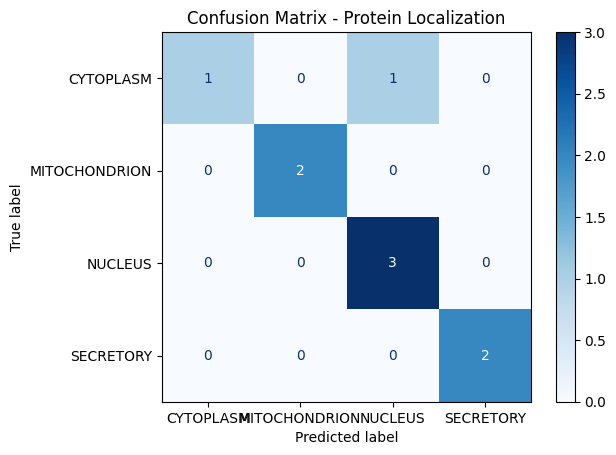

In [19]:

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix - Protein Localization")
plt.grid(False)
plt.show()


Visualizes model predictions using a confusion matrix.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


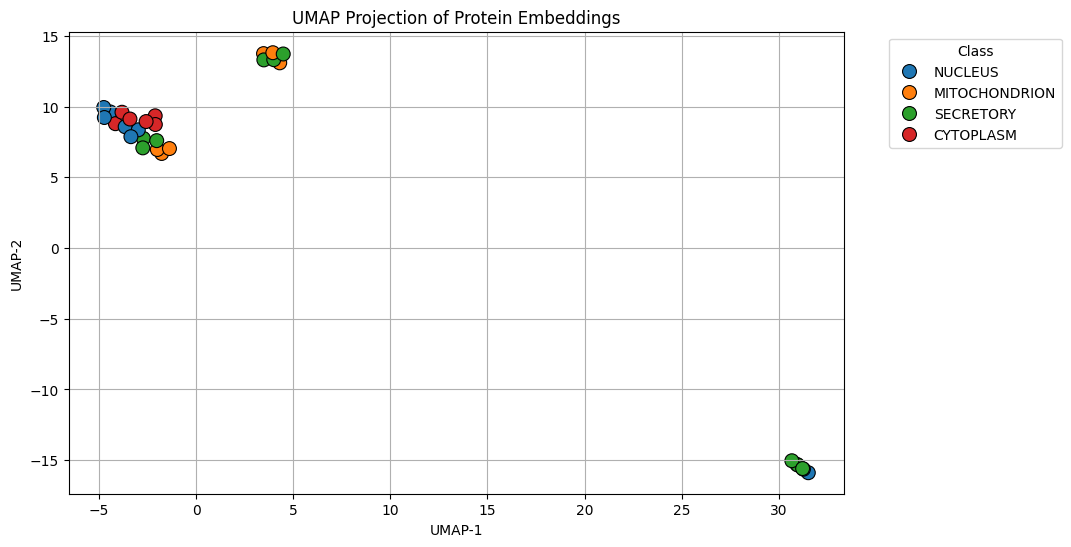

In [20]:

reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine')
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=[le.inverse_transform([label])[0] for label in y], palette='tab10', s=100, edgecolor='k')
plt.title("UMAP Projection of Protein Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Uses UMAP for dimensionality reduction and creates a scatter plot color-coded by class label.

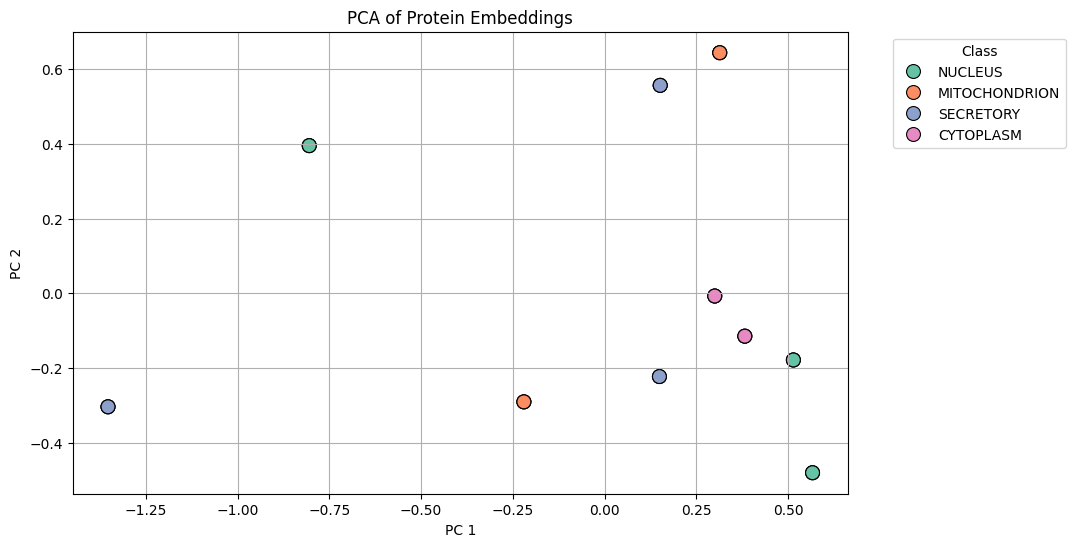

In [21]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=[le.inverse_transform([label])[0] for label in y], palette='Set2', s=100, edgecolor='k')
plt.title("PCA of Protein Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Visualizes the high-dimensional embeddings using PCA as an alternative to UMAP.

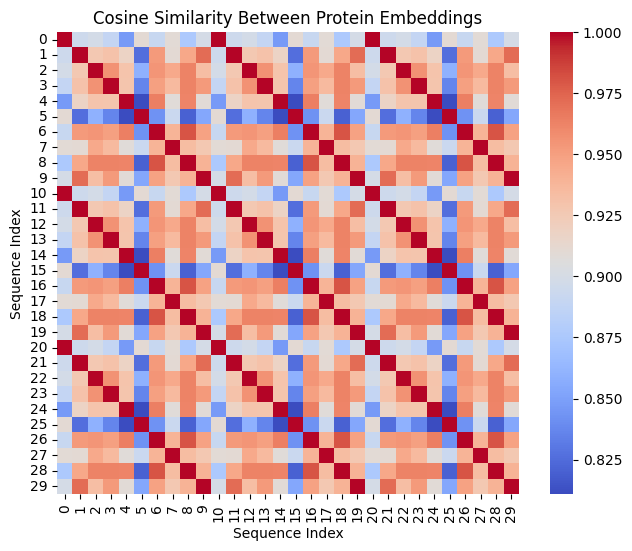

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

sim_matrix = cosine_similarity(X)

plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, cmap='coolwarm', square=True)
plt.title("Cosine Similarity Between Protein Embeddings")
plt.xlabel("Sequence Index")
plt.ylabel("Sequence Index")
plt.show()


Generates fixed-size embeddings for each protein sequence using the `[CLS]` token representation from the ProtBERT model. The resulting matrix `X` is used for similarity, classification, and projection analyses.

In [23]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X, y)
print(f"Silhouette Score (based on ProtBERT embeddings): {sil_score:.4f}")

Silhouette Score (based on ProtBERT embeddings): 0.1338


The Silhouette Score quantifies how well each protein sequence fits within its assigned class cluster compared to other clusters. A score closer to 1 indicates highly distinct clusters, while a score near 0 indicates overlapping class distributions.